<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/deeplearning.ai/tf/c2_rock_paper_scissors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [43]:
%matplotlib inline

import pathlib
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [8]:
BATCH_SIZE = 126
IMG_SIZE = (150, 150)

In [24]:
train_zip_url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip'
validation_zip_url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip'

train_path_to_zip = tf.keras.utils.get_file('rps.zip', 
                                            origin=train_zip_url,
                                            extract=True)

validation_path_to_zip = tf.keras.utils.get_file('rps-test.zip', 
                                                 origin=test_zip_url,
                                                 extract=True)

train_path = os.path.join(os.path.dirname(train_path_to_zip), 'rps')
validation_path = os.path.join(os.path.dirname(validation_path_to_zip), 
                               'rps-test-set')

print(f'train_path_to_zip: {train_path_to_zip}')
print(f'validation_path_to_zip: {validation_path_to_zip}')
print(f'train_path: {train_path}')
print(f'validation_path: {validation_path}')

train_path_to_zip: /root/.keras/datasets/rps.zip
validation_path_to_zip: /root/.keras/datasets/rps-test.zip
train_path: /root/.keras/datasets/rps
validation_path: /root/.keras/datasets/rps-test-set


In [25]:
train_ds = image_dataset_from_directory(
    directory=train_path,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE)

validation_ds = image_dataset_from_directory(
    directory=validation_path,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE)

Found 2520 files belonging to 3 classes.
Found 372 files belonging to 3 classes.


In [28]:
class_names = train_ds.class_names
assert train_ds.class_names == validation_ds.class_names
class_names

['paper', 'rock', 'scissors']

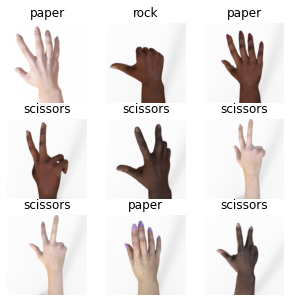

In [45]:
plt.figure(figsize=(5, 5))
images, labels =  next(iter(train_ds.take(1)))
print()
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[i].numpy().astype('uint8'))
  plt.title(class_names[np.argmax(labels[i])])
  plt.axis('off')